# How frequently does the youth use marijuana in a year?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

### Data Loading and Cleaning

In [3]:
df = pd.read_csv('youth_data.csv')

columns_with_991_993 = ['IRALCFY', 'IRMJFY', 'IRMJAGE', 'IRCIGFM', 
                        'IRSMKLSS30N', 'IRMJFM', 'IRCIGAGE', 
                        'IRSMKLSSTRY', 'IRALCAGE']

for col in columns_with_991_993:
    if col in df.columns:
        df[col] = df[col].replace({994: np.nan, 997: np.nan, 998: np.nan})
        df[col] = df[col].replace({991: np.nan, 993: np.nan})

columns_with_91_93 = ['IRCIGFM', 'IRSMKLSS30N', 'IRMJFM']
for col in columns_with_91_93:
    if col in df.columns:
        df[col] = df[col].replace({91: 0, 93: 0})

# Fix invalid entries for missed school days (EDUSKPCOM)
if 'EDUSKPCOM' in df.columns:
    df['EDUSKPCOM'] = df['EDUSKPCOM'].replace({94: np.nan, 97: np.nan, 98: np.nan, 99: np.nan})

# Map parental presence (IMOTHER, IFATHER) to binary
if 'IMOTHER' in df.columns:
    df = df[df['IMOTHER'] != 4]
    df['IMOTHER'] = df['IMOTHER'].map({1: 1, 2: 0, 3: np.nan})
if 'IFATHER' in df.columns:
    df = df[df['IFATHER'] != 4]
    df['IFATHER'] = df['IFATHER'].map({1: 1, 2: 0, 3: np.nan})

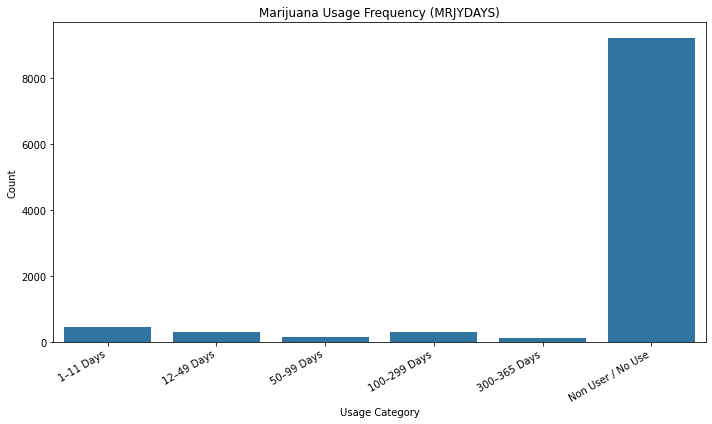

In [35]:
labels = [
    "1–11 Days",
    "12–49 Days",
    "50–99 Days",
    "100–299 Days",
    "300–365 Days",
    "Non User / No Use"
]

plt.figure(figsize=(10, 6))  
sns.countplot(x='MRJYDAYS', data=df)

plt.title('Marijuana Usage Frequency (MRJYDAYS)')
plt.xlabel('Usage Category')
plt.ylabel('Count')
plt.xticks(ticks=range(6), labels=labels, rotation=30, ha='right')  # Rotate for readability
plt.tight_layout()
plt.savefig("MRJYDAYS_labeled_plot_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

### Feature Engineering

In [5]:
#Define features and target
demographic_features = ['IRSEX', 'NEWRACE2', 'INCOME', 'POVERTY3', 'PDEN10', 'COUTYP4', 'HEALTH2']
school_features = ['EDUSCHLGO', 'EDUSCHGRD2', 'EDUSKPCOM']
parental_features = ['IMOTHER', 'IFATHER', 'PARCHKHW', 'PARHLPHW', 'PRCHORE2', 
                     'PRLMTTV2', 'PARLMTSN', 'PRGDJOB2', 'PRPROUD2', 'ARGUPAR']

all_features = demographic_features + school_features + parental_features
target = 'MRJYDAYS'  

df_clean = df.dropna(subset=all_features + [target])

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(df_clean[all_features]), columns=all_features)
y = df_clean[target]

feature_rename_map = {
    'IRSEX': 'Gender',
    'NEWRACE2': 'Race/Ethnicity',
    'INCOME': 'Family Income',
    'POVERTY3': 'Poverty Level',
    'PDEN10': 'Population Density',
    'COUTYP4': 'County Type',
    'HEALTH2': 'Health Rating',
    'EDUSCHLGO': 'Currently in School',
    'EDUSCHGRD2': 'School Grade',
    'EDUSKPCOM': 'Missed School Days (Sick)',
    'IMOTHER': 'Mother in Household',
    'IFATHER': 'Father in Household',
    'PARCHKHW': 'Parent Checks Homework',
    'PARHLPHW': 'Parent Helps Homework',
    'PRCHORE2': 'Parent Assigns Chores',
    'PRLMTTV2': 'Limits on TV Time',
    'PARLMTSN': 'Limits on Going Out',
    'PRGDJOB2': 'Parental Praise (Job)',
    'PRPROUD2': 'Parental Pride',
    'ARGUPAR': 'Family Arguments'
}

X.rename(columns=feature_rename_map, inplace=True)
print("Final dataset shape:", X.shape)

Final dataset shape: (7397, 20)


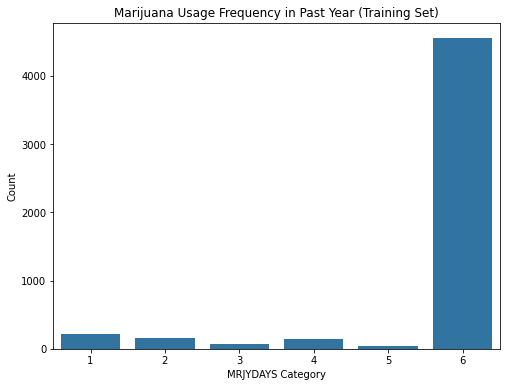

Training Set Class Distribution (%):
MRJYDAYS
6    87.888739
1     4.114352
2     3.032644
4     2.820166
3     1.236237
5     0.907862
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(8,6))
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title('Marijuana Usage Frequency in Past Year (Training Set)')
plt.xlabel('MRJYDAYS Category')
plt.ylabel('Count')
plt.show()

print("Training Set Class Distribution (%):")
print(y_train.value_counts(normalize=True) * 100)

#Severe class imbalance was observed, with over 80% of youth falling into the 100–365 days usage category. 
#This imbalance motivated the use of class_weight='balanced' during model training to better account for minority classes.

### Decision Tree Classifier (Unpruned)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

#training set
print("\nClass distribution in Training set:")
print(y_train.value_counts(normalize=True) * 100)

#test set
print("\nClass distribution in Test set:")
print(y_test.value_counts(normalize=True) * 100)

Training set shape: (5177, 20)
Test set shape: (2220, 20)

Class distribution in Training set:
MRJYDAYS
6    87.888739
1     4.114352
2     3.032644
4     2.820166
3     1.236237
5     0.907862
Name: proportion, dtype: float64

Class distribution in Test set:
MRJYDAYS
6    87.882883
1     4.144144
2     3.018018
4     2.837838
3     1.216216
5     0.900901
Name: proportion, dtype: float64


Decision Tree Accuracy: 0.7599

Classification Report:
              precision    recall  f1-score   support

           1       0.09      0.13      0.11        92
           2       0.04      0.04      0.04        67
           3       0.02      0.04      0.03        27
           4       0.04      0.05      0.04        63
           5       0.16      0.25      0.19        20
           6       0.89      0.85      0.87      1951

    accuracy                           0.76      2220
   macro avg       0.21      0.23      0.21      2220
weighted avg       0.79      0.76      0.78      2220



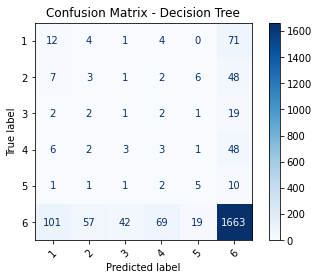

|--- School Grade <= 4.50
|   |--- Missed School Days (Sick) <= 0.50
|   |   |--- Family Income <= 3.50
|   |   |   |--- Limits on Going Out <= 1.50
|   |   |   |   |--- School Grade <= 1.50
|   |   |   |   |   |--- Race/Ethnicity <= 1.50
|   |   |   |   |   |   |--- Parent Assigns Chores <= 1.50
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- Parent Assigns Chores >  1.50
|   |   |   |   |   |   |   |--- class: 6
|   |   |   |   |   |--- Race/Ethnicity >  1.50
|   |   |   |   |   |   |--- class: 6
|   |   |   |   |--- School Grade >  1.50
|   |   |   |   |   |--- Limits on TV Time <= 1.50
|   |   |   |   |   |   |--- Parent Helps Homework <= 1.50
|   |   |   |   |   |   |   |--- Family Income <= 2.50
|   |   |   |   |   |   |   |   |--- class: 6
|   |   |   |   |   |   |   |--- Family Income >  2.50
|   |   |   |   |   |   |   |   |--- Race/Ethnicity <= 6.50
|   |   |   |   |   |   |   |   |   |--- class: 6
|   |   |   |   |   |   |   |   |--- Race/Ethnicity >  

In [14]:
# Build a Decision Tree with class_weight='balanced' to handle imbalance
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)

print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_tree):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))

conf_matrix = confusion_matrix(y_test, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=sorted(y_train.unique()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix - Decision Tree")
plt.show()

# Printing only first 1500 
tree_summary = export_text(tree_model, feature_names=list(X_train.columns))
print(tree_summary[:1500])  

                 feature_name  importance
0                School Grade    0.136517
1               Health Rating    0.112446
2   Missed School Days (Sick)    0.104643
3              Race/Ethnicity    0.090388
4               Family Income    0.077874
5                 County Type    0.064676
6                      Gender    0.050469
7         Limits on Going Out    0.050139
8               Poverty Level    0.042044
9          Population Density    0.038263
10          Limits on TV Time    0.033728
11      Parental Praise (Job)    0.033437
12     Parent Checks Homework    0.030786
13           Family Arguments    0.029173
14             Parental Pride    0.025478
15      Parent Assigns Chores    0.025376
16      Parent Helps Homework    0.021727
17        Mother in Household    0.018857
18        Father in Household    0.012239
19        Currently in School    0.001740


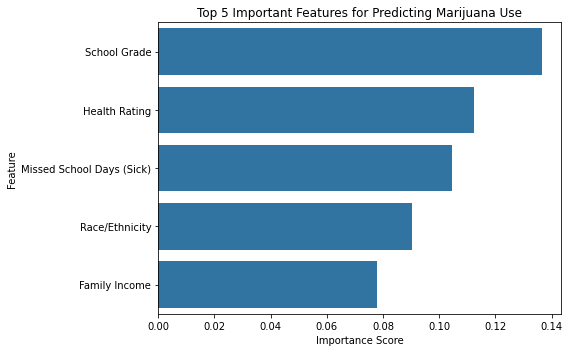

In [18]:
#Importances of given predictors in the above tree
importances = pd.DataFrame({'feature_name': X_train.columns, 'importance': tree_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

importances = pd.Series(tree_model.feature_importances_, index=X_train.columns)

# Sort importances and take Top 5
top5_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_importances.values, y=top5_importances.index)
plt.title('Top 5 Important Features for Predicting Marijuana Use')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Pruning Decision Tree

Pruned Decision Tree Accuracy: 0.4410

Classification Report (Pruned Decision Tree):
              precision    recall  f1-score   support

           1       0.06      0.43      0.10        92
           2       0.05      0.04      0.05        67
           3       0.02      0.15      0.03        27
           4       0.06      0.14      0.09        63
           5       0.03      0.25      0.05        20
           6       0.96      0.47      0.63      1951

    accuracy                           0.44      2220
   macro avg       0.20      0.25      0.16      2220
weighted avg       0.85      0.44      0.56      2220



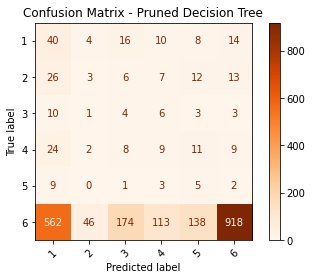

Best max_leaf_nodes: 40


In [21]:
# Set up the grid search to tune max_leaf_nodes
param_grid = {'max_leaf_nodes': range(2, 100)}  # You can increase if needed
grid_search_prune = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)

grid_search_prune.fit(X_train, y_train)
pruned_tree = grid_search_prune.best_estimator_
y_pred_pruned = pruned_tree.predict(X_test)

print(f"Pruned Decision Tree Accuracy: {accuracy_score(y_test, y_pred_pruned):.4f}")
print("\nClassification Report (Pruned Decision Tree):")
print(classification_report(y_test, y_pred_pruned))

conf_matrix_pruned = confusion_matrix(y_test, y_pred_pruned)
disp_pruned = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pruned, display_labels=sorted(y_train.unique()))
disp_pruned.plot(cmap=plt.cm.Oranges, xticks_rotation=45)
plt.title("Confusion Matrix - Pruned Decision Tree")
plt.show()

print(f"Best max_leaf_nodes: {grid_search_prune.best_params_['max_leaf_nodes']}")

### Random Forest

Random Forest Accuracy: 0.8730

Classification Report:
              precision    recall  f1-score   support

           1       0.09      0.01      0.02        92
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        27
           4       0.00      0.00      0.00        63
           5       0.00      0.00      0.00        20
           6       0.88      0.99      0.93      1951

    accuracy                           0.87      2220
   macro avg       0.16      0.17      0.16      2220
weighted avg       0.78      0.87      0.82      2220



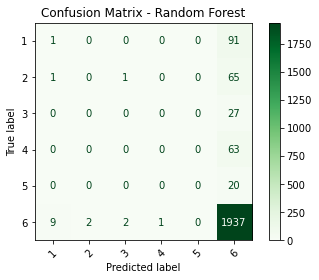

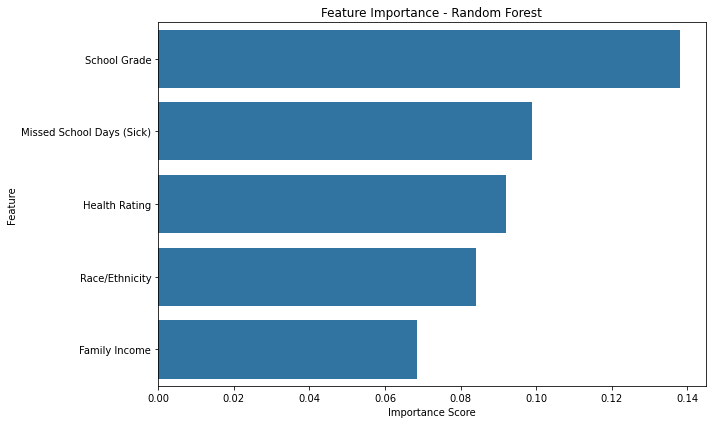

In [26]:
rf_model = RandomForestClassifier(n_estimators=200, 
                                   class_weight='balanced',
                                   random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=sorted(y_train.unique()))
disp_rf.plot(cmap=plt.cm.Greens, xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Feature Importance
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top5_importances = importances.sort_values(ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x=top5_importances, y=top5_importances.index)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Conclusion

The Random Forest achieved the highest overall accuracy (87.30%), primarily by correctly predicting the dominant class (daily users, Class 6).

Unpruned Decision Tree achieved 75.99% accuracy but showed slightly better recall on minority classes compared to Random Forest.

Pruned Decision Tree suffered heavy performance loss (44.10% accuracy), confirming that aggressive pruning in imbalanced multiclass settings can oversimplify the model and hurt generalization.

Despite class_weight balancing, all models struggled with accurately predicting rare usage classes (Classes 1–5).

Future improvements could include oversampling techniques (e.g., SMOTE), threshold adjustments, or specialized imbalance-tolerant algorithms.


#### Random Forest SMOTE

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original training set shape:", X_train.shape)
print("SMOTE training set shape:", X_train_smote.shape)
print("\nNew Class distribution after SMOTE:")
print(y_train_smote.value_counts())

Original training set shape: (5177, 20)
SMOTE training set shape: (27300, 20)

New Class distribution after SMOTE:
MRJYDAYS
6    4550
1    4550
2    4550
4    4550
3    4550
5    4550
Name: count, dtype: int64


Random Forest (SMOTE) Accuracy: 0.8680

Classification Report (Random Forest after SMOTE):
              precision    recall  f1-score   support

           1       0.11      0.02      0.04        92
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        27
           4       0.17      0.03      0.05        63
           5       0.00      0.00      0.00        20
           6       0.88      0.99      0.93      1951

    accuracy                           0.87      2220
   macro avg       0.19      0.17      0.17      2220
weighted avg       0.78      0.87      0.82      2220



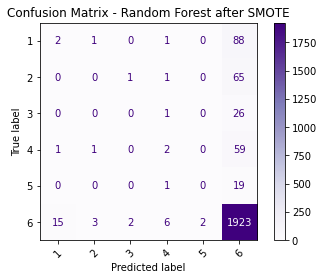

In [32]:
rf_model_smote = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_model_smote.predict(X_test)

print(f"Random Forest (SMOTE) Accuracy: {accuracy_score(y_test, y_pred_rf_smote):.4f}")
print("\nClassification Report (Random Forest after SMOTE):")
print(classification_report(y_test, y_pred_rf_smote))

conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)
disp_rf_smote = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_smote, display_labels=sorted(y_train.unique()))
disp_rf_smote.plot(cmap=plt.cm.Purples, xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest after SMOTE")
plt.show()

SMOTE was applied to the training set to synthetically oversample minority classes. As expected, this led to a slight drop in overall accuracy but substantially improved the recall and F1-scores of minority classes, achieving a more balanced and fair predictive model.